In [1]:
import numpy as np 
import pandas as pd
import datetime
import os
import time
import gc
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#better visualisation
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

# Glimps at the data

In [2]:
train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time','attributed_time','is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

train = pd.read_csv("D:/input/train.csv", nrows=10000000, usecols=train_columns, dtype=dtypes)
test = pd.read_csv("D:/input/test.csv", usecols=test_columns, dtype=dtypes)

In [3]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [4]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


#### There is a total of 7 features:

    ip: Encoded ip address of the click
    app: Encoded app for marketing
    device: Encoded device type of user mobile phone
    os: Encoded os version of user mobile phone
    channel: Encoded channel of mobile ad publisher
    click_time: timestamp of the click (UTC)
    attributed_time: if the user downloader the app , this is the time he did so.

#### Nota bene:

    is_attributed is a binary target to predict
    ip, app, device, os, channel are encoded
    attributed_time is not available in the test set




In [5]:
variables = ['ip', 'app', 'device', 'os', 'channel']
for v in variables:
    train[v] = train[v].astype('category')
    test[v]=test[v].astype('category')

In [6]:
#set click_time and attributed_time as timeseries
train['click_time'] = pd.to_datetime(train['click_time'])
#train['attributed_time'] = pd.to_datetime(train['attributed_time'])
test['click_time'] = pd.to_datetime(test['click_time'])

#set as_attributed in train as a categorical
train['is_attributed']=train['is_attributed'].astype('category')

In [7]:
train.describe()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000,18717,10000000.0
unique,68740.0,332.0,940.0,292.0,170.0,29943,15698,2.0
top,73516.0,12.0,1.0,19.0,245.0,2017-11-06 16:05:10,2017-11-06 23:36:23,0.0
freq,51711.0,1291185.0,9381146.0,2410148.0,793105.0,1261,6,9981283.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 14:32:21,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-07 00:12:03,NaN,NaN


In [8]:
#double check that 'attributed_time' is not Null for all values that resulted in download 
train[['attributed_time', 'is_attributed']][train['is_attributed']==1].describe()

,attributed_time,is_attributed
count,18717,18717
unique,15698,1
top,2017-11-06 23:36:23,1
freq,6,18717


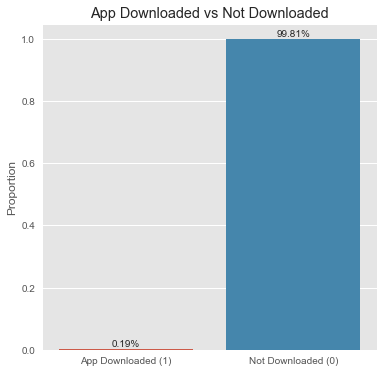

In [9]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
plt.style.use('ggplot')
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

There are only 18717 attributed_time values. This means only 18,717 out of 10,000,000 clicks resulted in a download. That's less than 0.2% !

####  we can't use accuracy as a metric for training  due to the unbalance , the area under the roc curve is a better metric in this case

In [10]:
#set click_id to categorical, for cleaner statistics view
test['click_id']=test['click_id'].astype('category')
test.describe()

,click_id,ip,app,device,os,channel,click_time
count,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469
unique,18790469.0,93936.0,417.0,1985.0,395.0,178.0,21603
top,18790468.0,5348.0,9.0,1.0,19.0,107.0,2017-11-10 09:00:10
freq,1.0,182522.0,2872176.0,17360269.0,4334532.0,1214650.0,1466
first,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 04:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 15:00:00


First click in train set is on 2017-11-06 14:32:21. Test clicks start on 2017-11-10.

Based on data specifications, train coveres a 4 day period. This means that the train and test data do not overlap, but test data is taken the day after train data ends.

2017-11-06 was a Monday. 2017-11-10 was a Friday. i.e. Train is Mon-Thur, Test is Friday -There is no missing data in Test. Missing values in train appear to be only for attributed_time, where there isn't any value due to no app download.

In [12]:
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'click_per_ip']
temp[:10]

,ip,click_per_ip
0,73516,51711
1,73487,51215
2,5314,35073
3,5348,35004
4,53454,25381
5,105560,23289
6,100275,23070
7,114276,22774
8,201182,22719
9,105475,22047


Text(0.5,1,'Number of click by IP')

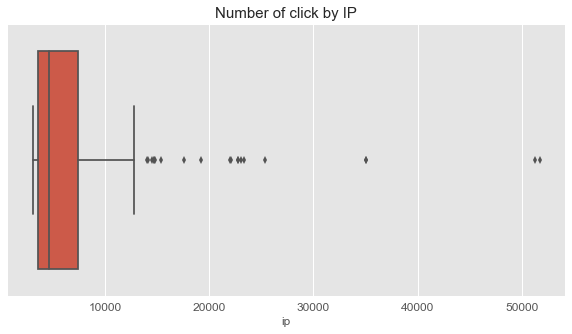

In [26]:
# We can now take a first look at those IP
plt.figure(figsize = [10,5])
sns.boxplot(x=train['ip'].value_counts().head(200)) 
plt.title('Number of click by IP', fontsize =15)


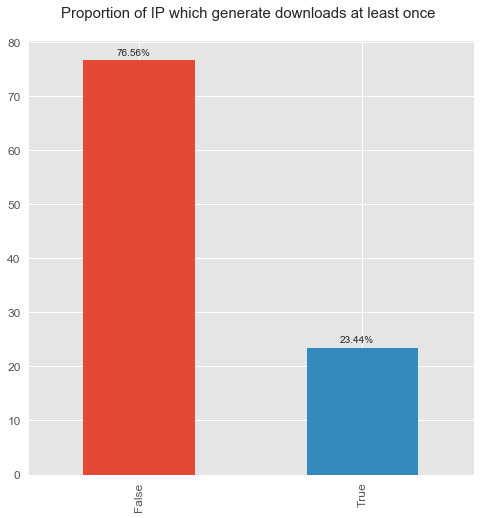

In [27]:
train['is_attributed']=train['is_attributed'].astype('uint8')
DL_by_IP = train.groupby('ip').is_attributed.sum()
plt.figure(figsize=(8,8))
plt.title('Proportion of IP which generate downloads at least once \n', fontsize =15)
ax =((DL_by_IP > 0).value_counts(normalize=True)*100).plot(kind='bar')

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

### conclusion : IP is an important feature , we should keep it

In [4]:
train_smp = pd.read_csv("D:/input/train_sample.csv" , usecols= train_columns , dtype=dtypes)
#convert click_time and attributed_time to time series
train_smp['click_time'] = pd.to_datetime(train_smp['click_time'])
train_smp['attributed_time'] = pd.to_datetime(train_smp['attributed_time'])


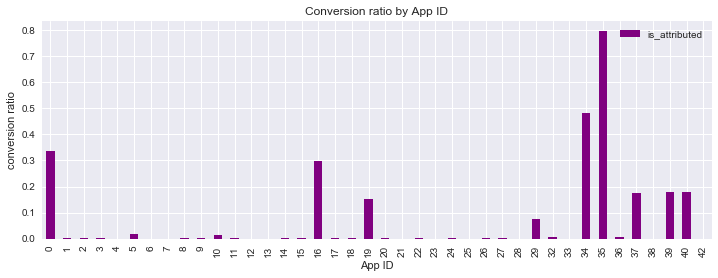

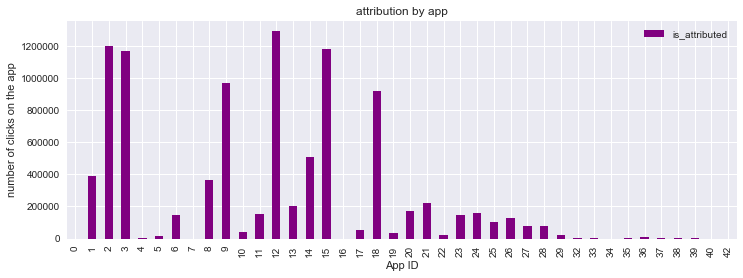

In [35]:

%matplotlib inline

train[['app','is_attributed']].groupby(['app'], as_index=True).mean().head(40).plot(figsize=(12,4),kind='bar',
                                                                               color='purple')
plt.title('Conversion ratio by App ID')
plt.ylabel('conversion ratio');
plt.xlabel('App ID');

train[['app','is_attributed']].groupby(['app'], as_index=True).count().head(40).plot(figsize=(12,4),kind='bar', color='purple')
plt.title('attribution by app')
plt.ylabel('number of clicks on the app');
plt.xlabel('App ID');

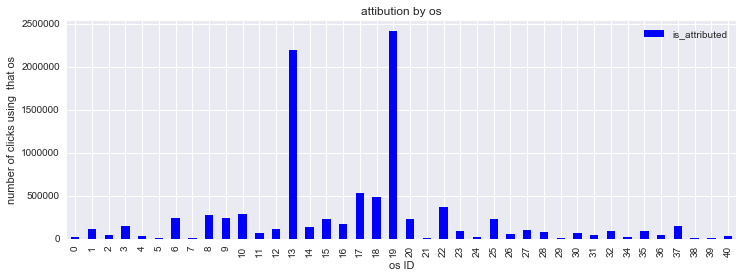

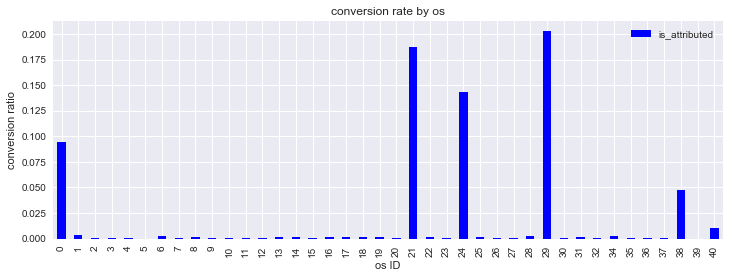

In [38]:
train[['os','is_attributed']].groupby(['os'], as_index=True).count().head(40).plot(figsize=(12,4),kind='bar', color='blue')
plt.title('attibution by os')
plt.ylabel('number of clicks using  that os');
plt.xlabel('os ID');

train[['os','is_attributed']].groupby(['os'], as_index=True).mean().head(40).plot(figsize=(12,4),kind='bar' , color='blue')
plt.title('conversion rate by os')
plt.ylabel('conversion ratio');
plt.xlabel('os ID');

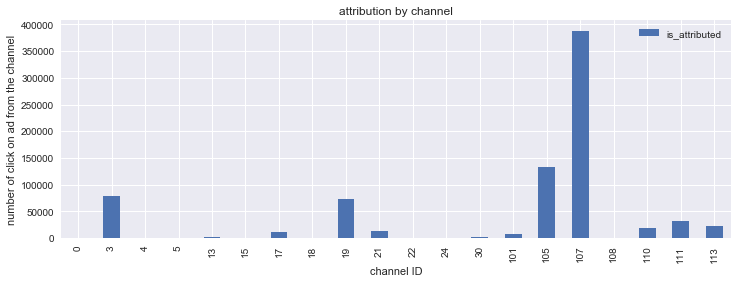

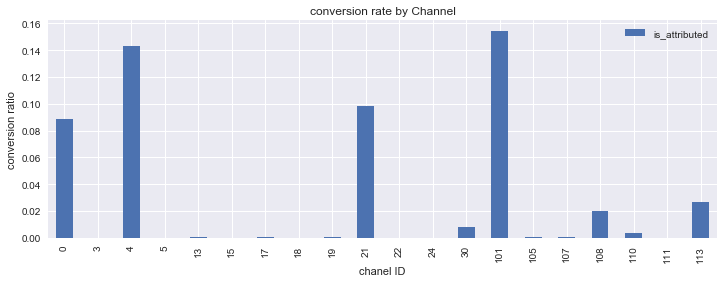

In [40]:

train[['channel','is_attributed']].groupby(['channel'], as_index=True).count().head(20).plot(figsize=(12,4),kind='bar')
plt.title('attribution by channel')
plt.ylabel('number of click on ad from the channel');
plt.xlabel('channel ID');

train[['channel','is_attributed']].groupby(['channel'], as_index=True).mean().head(20).plot(figsize=(12,4),kind='bar')
plt.title('conversion rate by Channel')
plt.ylabel('conversion ratio');
plt.xlabel('chanel ID');



specific channels seem to have more attributions than others

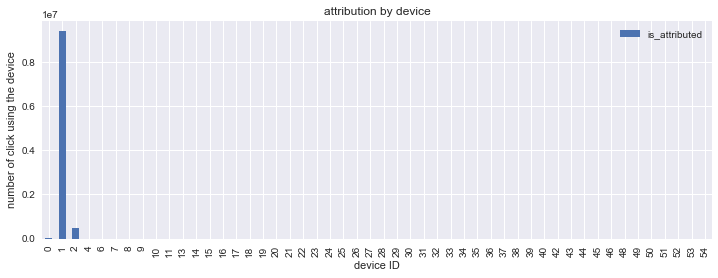

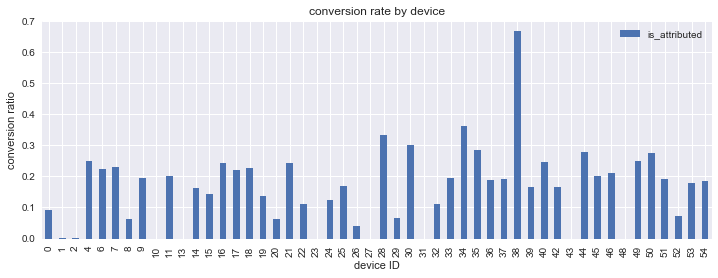

In [43]:
train[['device','is_attributed']].groupby(['device'], as_index=True).count().head(50).plot(figsize=(12,4),kind='bar')
plt.title('attribution by device')
plt.ylabel('number of click using the device');
plt.xlabel('device ID');

train[['device','is_attributed']].groupby(['device'], as_index=True).mean().head(50).plot(figsize=(12,4),kind='bar')
plt.title('conversion rate by device')
plt.ylabel('conversion ratio');
plt.xlabel('device ID');

# Time patterns

In [38]:
train_smp.head(5)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0


For this part we can't use the first n rows from train data, as it's organized by time. To get a general idea for the pattern, i use train data from the randomly sampled 100000 train set provided by kaggle.

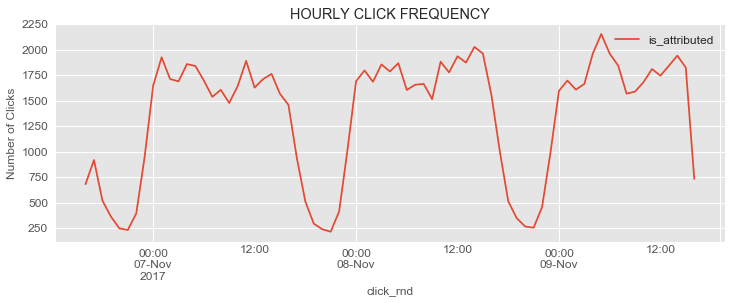

In [39]:
#round the time to nearest hour
train_smp['click_rnd']=train_smp['click_time'].dt.round('H')  
#check for hourly patterns
train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot(figsize=(12,4))
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');




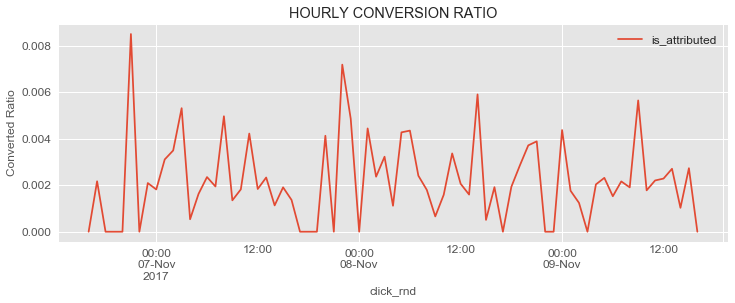

In [40]:
train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot(figsize=(12,4))
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

There is no clear hourly time pattern in ratios, however there is a definete pattern in frequency of clicks based on time of day.
let's extract time features and do some tests

In [41]:
train_smp['click_hour'] = pd.to_datetime(train_smp.click_time).dt.hour.astype('uint8')


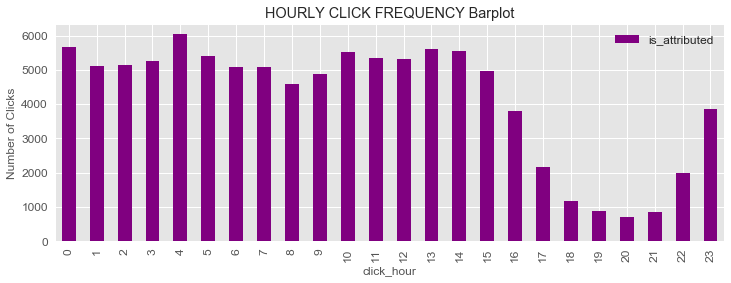

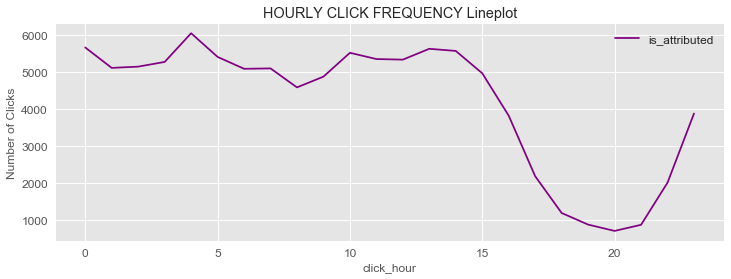

In [42]:


train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(figsize=(12,4),kind='bar', color='purple')
plt.title('HOURLY CLICK FREQUENCY Barplot');
plt.ylabel('Number of Clicks');

train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(figsize=(12,4),color='purple')
plt.title('HOURLY CLICK FREQUENCY Lineplot');
plt.ylabel('Number of Clicks');



there is clearly some hours white more conversion than others so we will keep this feature 

In [46]:
def prep_data(df):
    print("Creating new time features: 'hour' , 'day', 'minutes' , 'secondes'...")
    df['hour'] = pd.to_datetime(df.click_time).dt.hour.astype('uint8')
    df['day'] = pd.to_datetime(df.click_time).dt.day.astype('uint8')
    df['minute'] = pd.to_datetime(df.click_time).dt.minute.astype('uint8')
    df['seconde'] = pd.to_datetime(df.click_time).dt.second.astype('uint8')
    print('1. Computing the number of clicks associated with a given IP address within each hour... ')
    temp = df[['ip','day','hour','channel']].groupby(by=['ip','day',
          'hour'])[['channel']].count().reset_index().rename(columns={'channel': 'hourly_clicks'})
   
    df = df.merge(temp, on=['ip','day','hour'], how='left')
    del temp
    gc.collect()
    print('1. Computing the number of clicks associated with a given IP address within each minute... ')
    temp = df[['ip','day','hour','minute','channel']].groupby(by=['ip','day',
          'hour','minute'])[['channel']].count().reset_index().rename(columns={'channel': 'click_per_minute'})
    
    df = df.merge(temp, on=['ip','day','hour','minute'], how='left')
    del temp
    gc.collect()
    print('1. Computing the number of clicks associated with a given IP address within each seconde... ')
    temp = df[['ip','day','hour','minute','seconde','channel']].groupby(by=['ip','day',
          'hour','minute','seconde'])[['channel']].count().reset_index().rename(columns={'channel': 'click_per_seconde'})
    
    df = df.merge(temp, on=['ip','day','hour','minute','seconde'], how='left')
    del temp
    gc.collect()
          
          
    print('2. Computing the number of clicks associated with a given IP address and app...')
    n_channel = df[['ip','app', 'channel']].groupby(by=['ip', 
          'app'])[['channel']].count().reset_index().rename(columns={'channel': 'ip_app_count'})
    
    df = df.merge(n_channel, on=['ip','app'], how='left')
    del n_channel
    gc.collect()
    print('3. Computing the number of clicks associated with a given IP address, app, and os...')
    n_channel = df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 
          'os'])[['channel']].count().reset_index().rename(columns={'channel': 'ip_app_os_count'}) 
       
    df = df.merge(n_channel, on=['ip','app', 'os'], how='left')
    del n_channel
    gc.collect()
        
    df['hourly_clicks'] = df['hourly_clicks'].astype('uint16')
    df['ip_app_count'] = df['ip_app_count'].astype('uint16')
    df['ip_app_os_count'] = df['ip_app_os_count'].astype('uint16')
    df['click_per_seconde'] = df['click_per_seconde'].astype('uint16')
    df['click_per_minute'] = df['click_per_minute'].astype('uint16')
   
    df.drop(['click_time','day'], axis=1, inplace=True )
    gc.collect()
    return df

In [47]:
train = pd.read_csv("D:/input/train.csv", nrows=10000000, usecols=train_columns, dtype=dtypes)
train = prep_data(train)

Creating new time features: 'hour' , 'day', 'minutes' , 'secondes'...
1. Computing the number of clicks associated with a given IP address within each hour... 
1. Computing the number of clicks associated with a given IP address within each minute... 
1. Computing the number of clicks associated with a given IP address within each seconde... 
2. Computing the number of clicks associated with a given IP address and app...
3. Computing the number of clicks associated with a given IP address, app, and os...


In [17]:
import seaborn as sns

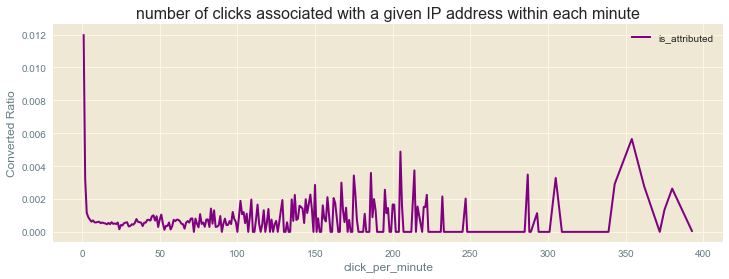

In [37]:
train[['click_per_minute','is_attributed']].groupby(['click_per_minute'], as_index=True).mean().plot(figsize=(12,4), color='purple')
plt.title('number of clicks associated with a given IP address within each minute');
plt.ylabel('Converted Ratio');

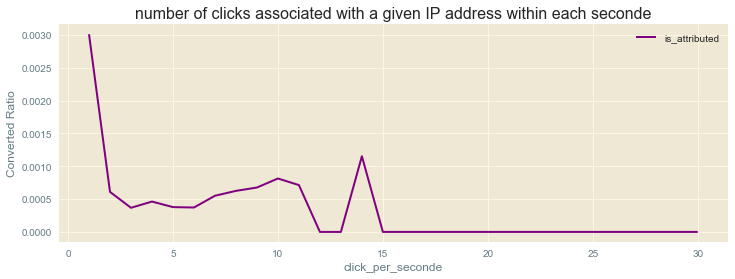

In [44]:
train[['click_per_seconde','is_attributed']].groupby(['click_per_seconde'], as_index=True).mean().plot(figsize=(12,4), color='purple')
plt.title('number of clicks associated with a given IP address within each seconde');
plt.ylabel('Converted Ratio');

There is clear correlation between low number click and high number of coversion

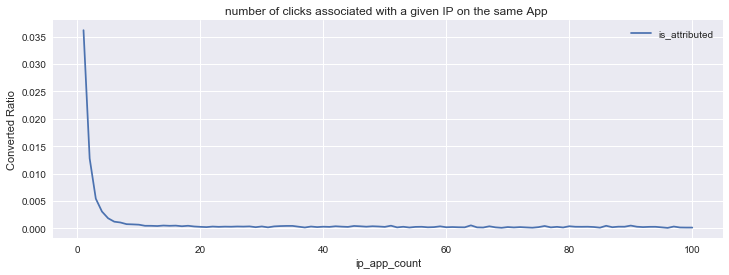

In [53]:

train[['ip_app_count','is_attributed']].groupby(['ip_app_count'], as_index=True).mean().head(100).plot(figsize=(12,4))
plt.title('number of clicks associated with a given IP on the same App ');
plt.ylabel('Converted Ratio');


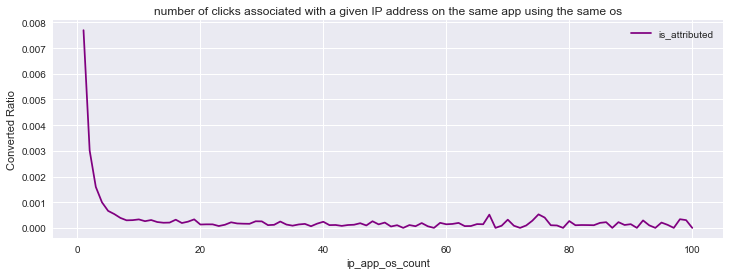

In [54]:
train[['ip_app_os_count','is_attributed']].groupby(['ip_app_os_count'], as_index=True).mean().head(100).plot(figsize=(12,4), color='purple')
plt.title('number of clicks associated with a given IP address on the same app using the same os');
plt.ylabel('Converted Ratio');

### maybe IP doesn't represent the ip adresse of a single user but may represent different groupe of users